In [1]:
from gensim.models import word2vec
import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import pickle
from scipy import sparse
import gc
import sys

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Create sequences and train word2vec

In [ ]:
model = gensim.models.Word2Vec.load("word2vec_128_window_500000000_iters_5_start_2000-01-01.bin")

In [2]:
load_pickle = False


start_date_train = '2009-01-01'
date_test = '2014-10-01'
min_seq_length = 5
max_seq_length = 100


movies_min_ratings = 20


if load_pickle:
    with open("../data/Movielens/ml-20m/df_date.pickle", 'rb') as handle:
        df_date = pickle.load(handle)
else:
    #Ratings .dat format: UserID::MovieID::Rating::Timestamp
    user_ids = []
    movie_ids = []
    ratings = []
    timestamps = []
    dataset_file = "../data/Movielens/ml-20m/ratings.csv"
    df = pd.read_csv(dataset_file)
    df['userId'] = df['userId'].astype(np.int32)
    df['movieId'] = df['movieId'].astype(np.int32)
    df['rating'] = df['rating'].astype(np.float16)
    df['date'] = pd.to_datetime(df['timestamp'],unit='s')

    df_date = df[df.date > start_date_train]

# Filter out movies with less than X ratings
filter_movies = df_date.movieId.value_counts()[(df_date.movieId.value_counts() > movies_min_ratings)].index.values
df_date = df_date[df_date.movieId.isin(filter_movies)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()
# Filter out users with less than X ratings
filter_users = df_date['userId'].value_counts()[(df_date['userId'].value_counts() >= min_seq_length)].index.values
df_date = df_date[df_date.userId.isin(filter_users)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))

# Build array mapping movie_id --> position in one-hot encoding
movieIds = np.zeros(max(df_date['movieId'].unique()) + 1, np.uint16)
i = 0
for movieId in df_date['movieId'].unique():
    movieIds[movieId] = i
    i += 1



seq_lengths = []
num_diff_items = len(df_date.movieId.unique())

grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1


Total number of ratings:4687202
Number of different users: 36395
Number of different movies: 10057
Total number of ratings:4685946
Number of different users: 35821
Number of different movies: 10057


In [3]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
# train word2vec on the two sentences
embedding_size = 100
window_size = 10
iters = 30
model = gensim.models.Word2Vec(movie_sequences,  size=embedding_size, window=window_size, min_count=1, iter=iters)
model.save("word2vec_" + str(embedding_size) + "_window_" + str(window_size) + "_iters_" + str(iters) + '_start_' + str(start_date_train) + ".bin")

2017-05-19 17:10:31,592 : INFO : collecting all words and their counts
2017-05-19 17:10:31,593 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-19 17:10:31,948 : INFO : PROGRESS: at sentence #10000, processed 1306399 words, keeping 10057 word types
2017-05-19 17:10:32,264 : INFO : PROGRESS: at sentence #20000, processed 2615188 words, keeping 10057 word types
2017-05-19 17:10:32,634 : INFO : PROGRESS: at sentence #30000, processed 3925079 words, keeping 10057 word types
2017-05-19 17:10:32,814 : INFO : collected 10057 word types from a corpus of 4685946 raw words and 35821 sentences
2017-05-19 17:10:32,824 : INFO : Loading a fresh vocabulary
2017-05-19 17:10:32,844 : INFO : min_count=1 retains 10057 unique words (100% of original 10057, drops 0)
2017-05-19 17:10:32,845 : INFO : min_count=1 leaves 4685946 word corpus (100% of original 4685946, drops 0)
2017-05-19 17:10:32,902 : INFO : deleting the raw counts dictionary of 10057 items
2017-05-19 17:10:32

# Load movies dataset

In [4]:
dataset_file = "../data/Movielens/ml-20m/movies.csv"
df_movies = pd.read_csv(dataset_file)
print(len(df_movies.movieId.unique()))
df_movies = df_movies[df_movies.movieId.isin(df_date.movieId.unique())]
print(len(df_movies.movieId.unique()))

# Preprocess year
years = []
for movie_title in df_movies.title:
    year = movie_title[movie_title.find("(")+1:movie_title.find(")")]
    if not year.isdigit():
        year = 0
    years.append(int(year))
df_movies['year'] = years

27278
10057


# Obtain most similar movies

In [450]:
# Find specific movie
df_movies[df_movies['title'].str.contains("Shining")]
# Find movie by genre
# df_movies[df_movies['genres'].str.contains("Musical")]

,movieId,title,genres,year
1230,1258,"Shining, The (1980)",Horror,1980


In [6]:
id_movie = 1
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=25, restrict_vocab=None)
movies = []
genres = []
similarities = []
ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_similars = pd.DataFrame()
df_similars['ids'] = ids
df_similars['movies'] = movies
df_similars['genres'] = genres
df_similars['similarities'] = similarities
df_similars

Movie:    movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  
0  1995  


,ids,movies,genres,similarities
0,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,0.596746
1,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,0.559960
2,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,0.546631
3,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,0.532143
4,590,Dances with Wolves (1990),Adventure|Drama|Western,0.508323
5,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,0.507669
6,1721,Titanic (1997),Drama|Romance,0.504398
7,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,0.502502
8,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.500985
9,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,0.498194


In [409]:
# Similarity between 2 movies
print(model.similarity('1', '3504'))

-0.092990463366


In [410]:
# Similarity between 2 movies
print(model.similarity('1', '8228'))

0.0828748244223


In [411]:
# Similarity between 2 movies
print(model.similarity('1', '3504'))

-0.092990463366


In [7]:
# 98124(Batman), 46530(Superman), 95510(The amazing Spider-man), 1(Toy-Story)
model.wv.doesnt_match("98124 46530 95510 1".split())

'1'

# T-SNE and PCA Visualizations# 

In [ ]:
# Train T-SNE with all the data
from sklearn.manifold import TSNE

data_tsne = []
dict_movieId_pos = {}
i = 0
for word in model.wv.vocab:
    vector = model[word]
    data_tsne.append(vector)
    dict_movieId_pos[word] = i
    i += 1
    
data_tsne = np.array(data_tsne)
print(data_tsne.shape)
model_tsn_all = TSNE(n_components=2, random_state=17)
Y_tsn_all = model_tsn_all.fit_transform(data_tsne)

# Create data frame
df_tsne = pd.concat([pd.DataFrame(Y_tsn_all),
                pd.Series(list(model.wv.vocab))],
               axis=1)

df_tsne.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_tsne.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
df_tsne['title'] = titles
df_tsne['genres'] = genres
df_tsne['years'] = years

(10057, 100)


KeyboardInterrupt: 

In [ ]:
# Train PCA with all the data
from sklearn.decomposition import PCA

vocab = list(model.wv.vocab)
X = model[vocab]

pca = PCA(n_components=2)
pca.fit(X)
X_pca_all = pca.transform(X)

# Create data frame
df_pca = pd.concat([pd.DataFrame(X_pca_all),
                pd.Series(vocab)],
               axis=1)

df_pca.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_pca.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
    
df_pca['title'] = titles
df_pca['genres'] = genres
df_pca['years'] = years

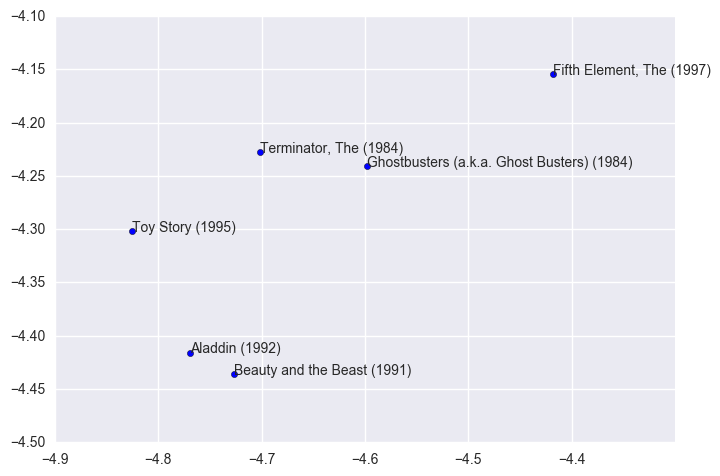

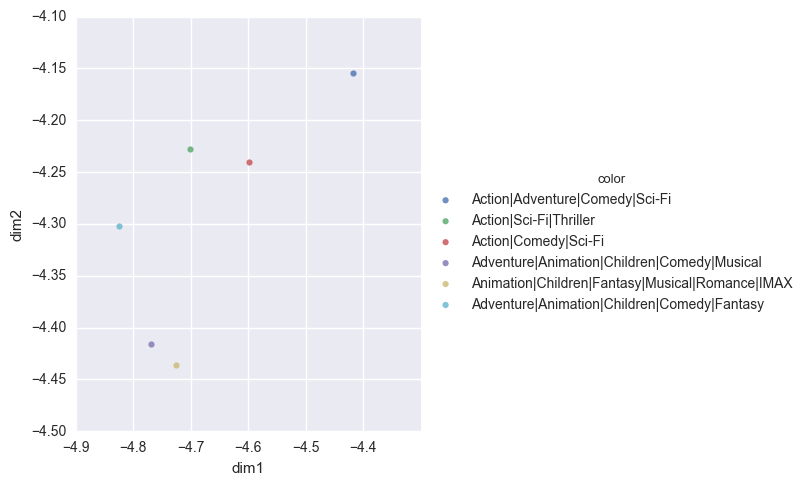

In [518]:
# Visualize n random examples with tsne with annotations
df_show = df_tsne.sample(n=10)

# Visualize specific movies 1(Toy Story), 595(Beautry and Beast), 588(Aladin), 1240(Terminator), 2985(Robocop),  
ids = [1, 595, 588, 1240, 2716, 1527]
ids = [str(i) for i in ids]
df_show = df_tsne[df_tsne.movie_id.isin(ids)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genres']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

# Plot per year (old/new)

In [519]:
df_tsne['year_category'] = 'Null'
df_tsne.loc[(df_tsne.years > 1900) & (df_tsne.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_tsne.loc[(df_tsne.years > 1950) & (df_tsne.years < 2000),'year_category'] = '1950-1990'
df_tsne.loc[(df_tsne.years > 2000),'year_category'] = 'New (2000 or newer)'

df_pca['year_category'] = 'Null'
df_pca.loc[(df_pca.years > 1900) & (df_pca.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_pca.loc[(df_pca.years > 1950) & (df_pca.years < 2000),'year_category'] = '1950-2000'
df_pca.loc[(df_pca.years > 2000),'year_category'] = 'New (2000 or newer)'

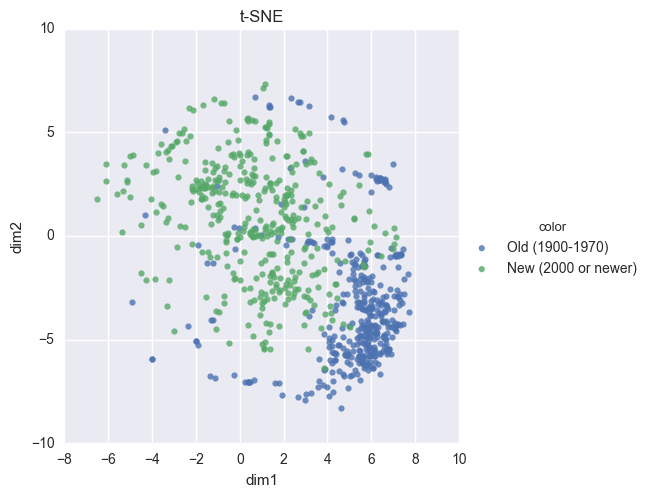

In [520]:
# Using the tsne with all the data
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

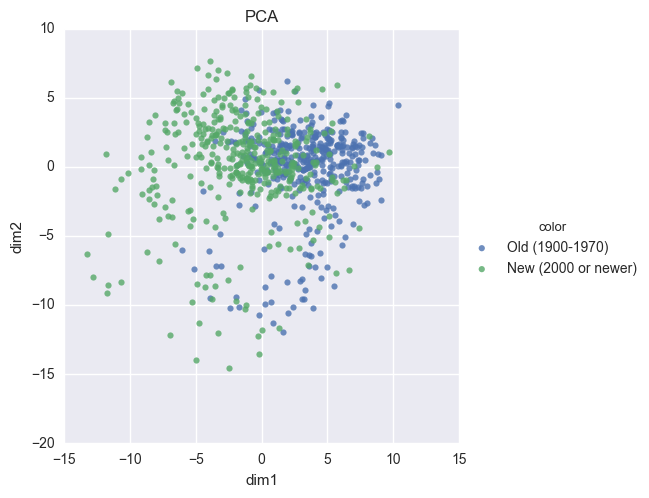

In [521]:
# Using the pca with all the data
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(800, 64)


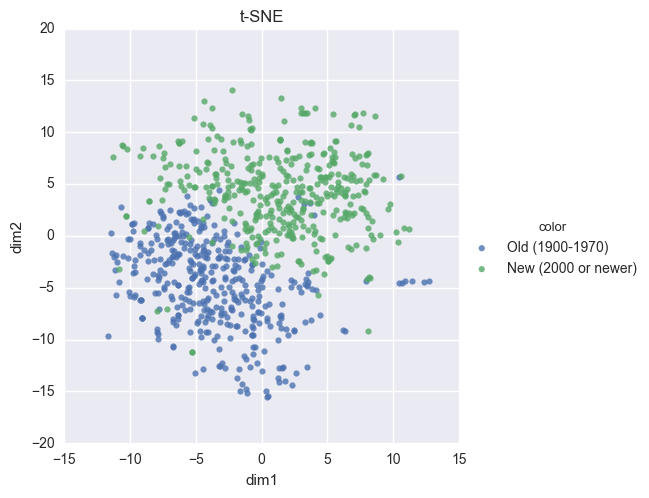

In [522]:
# Recomputing tsne for the selected samples
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(800, 64)


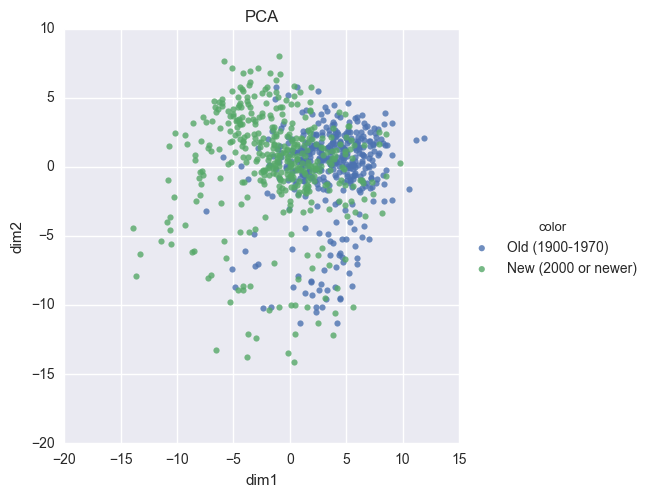

In [523]:
# Recomputing pca for the selected samples
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plot per genres

In [524]:
romance_genres = ['Comedy|Romance', 'Comedy|Musical|Romance', 'Musical|Romance', 'Fantasy|Musical|Romance', 'Romance', 'Comedy|Romance|Thriller',
                'Fantasy|Romance', 'Drama|Romance']
children_genres = ['Animation|Children|Fantasy', 'Action|Animation|Children|Comedy', 'Adventure|Animation|Children|Fantasy',
                  'Animation|Children', 'Adventure|Children|Fantasy', 'Action|Animation|Children', 'Adventure|Children',
                  'Adventure|Animation|Children', 'Children|Comedy|Fantasy', 'Children|Fantasy', 'Action|Children',
                  'Action|Children|Fantasy', 'Children', 'Animation|Children|Fantasy|IMAX', 'Action|Adventure|Children|IMAX',
                  'Adventure|Children|Comedy|Fantasy|Mystery', 'Adventure|Children|Drama|Fantasy', 'Animation|Children|Fantasy|IMAX',
                  'Children|Comedy']
horror_genres = ['Horror|Mystery|Thriller', 'Horror', 'Horror|Thriller', 'Action|Horror', 'Drama|Horror|Thriller'
                'Drama|Horror', 'Crime|Horror|Thriller', 'Action|Crime|Horror', 'Crime|Horror', 'Crime|Horror|Mystery'
                'Crime|Drama|Horror', ]

In [525]:
df_tsne['genre_1'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_tsne.loc[df_tsne.genres.isin(children_genres), 'genre_1'] = 'Children'
df_tsne.loc[df_tsne.genres.isin(horror_genres), 'genre_1'] = 'Horror'


df_pca['genre_1'] = 'Null'
df_pca.loc[df_pca.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_pca.loc[df_pca.genres.isin(children_genres), 'genre_1'] = 'Children'
df_pca.loc[df_pca.genres.isin(horror_genres), 'genre_1'] = 'Horror'

                         



In [526]:
print(len(df_tsne[df_tsne.genre_1 == 'Romance']))
print(len(df_tsne[df_tsne.genre_1 == 'Children']))
print(len(df_tsne[df_tsne.genre_1 == 'Horror']))

820
212
415


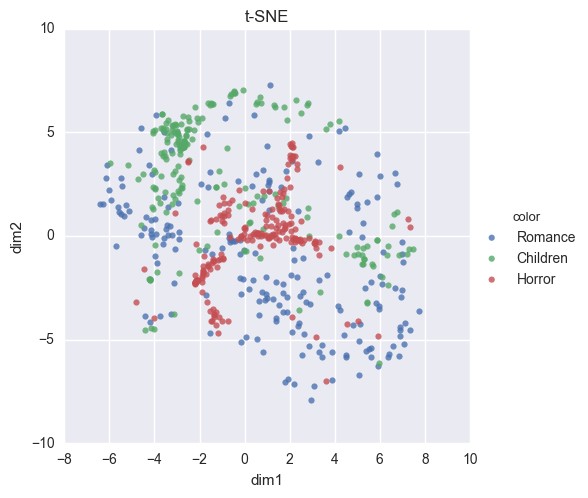

In [527]:
# Using the tsne with all the data
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

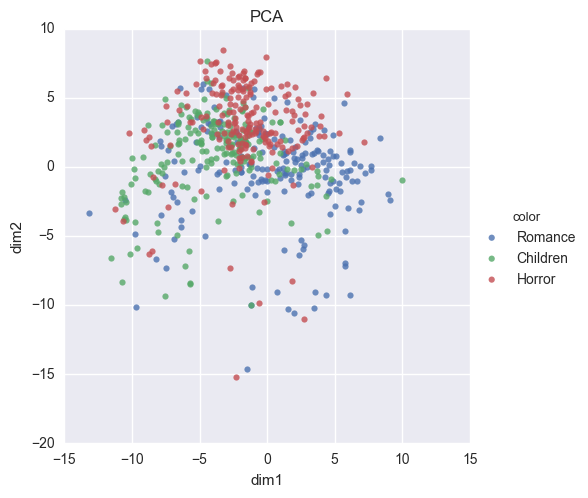

In [528]:
# Using the pca with all the data
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(600, 64)


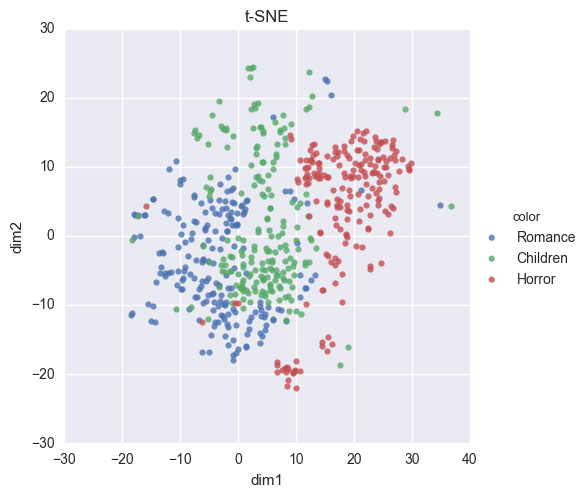

In [529]:
# Recomputing tsne for the selected samples
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(600, 64)


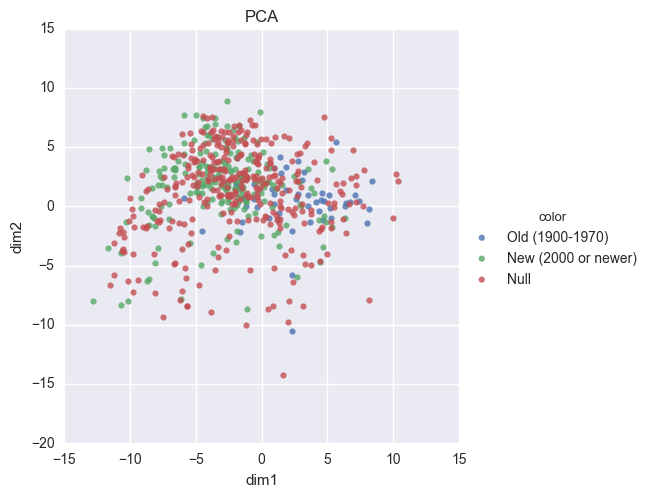

In [530]:
# Recomputing pca for the selected samples
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plot one Genre vs Other

In [531]:
# Drama vs Comedy 

drama_genres = ['Drama', 'Action|Crime|Drama', 'Drama|War', 'Crime|Drama', 'Drama|Thriller', 'Adventure|Drama',
               'Crime|Drama|Mystery', 'Drama|Mystery', 'Action|Drama|War', 'Drama|Thriller|War']
comedy_genres = ['Adventure|Comedy', 'Comedy|Romance', 'Comedy', 'Children|Comedy', 'Action|Comedy', 'Animation|Comedy',
                'Action|Comedy|IMAX']


df_tsne['genre_2'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_tsne.loc[df_tsne.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'



df_pca['genre_2'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_pca.loc[df_pca.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'



In [532]:
#for genre in df_pca.genres.unique():
    #if 'Comedy' in genre:
        #print(genre)

print(len(df_tsne[df_tsne.genre_2 == 'Drama']))
print(len(df_tsne[df_tsne.genre_2 == 'Comedy']))


1909
1314


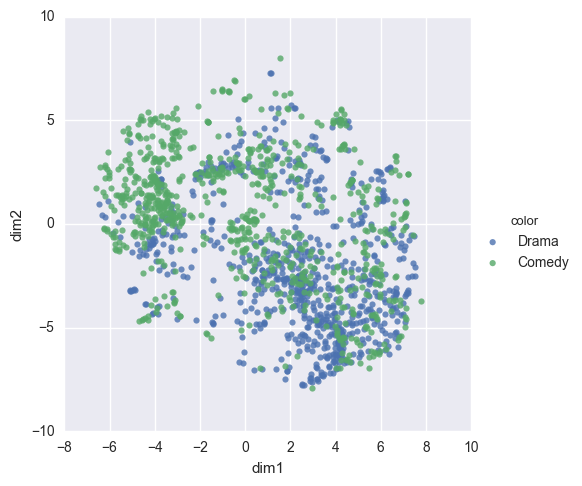

In [533]:
# Using the tsne with all the data
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

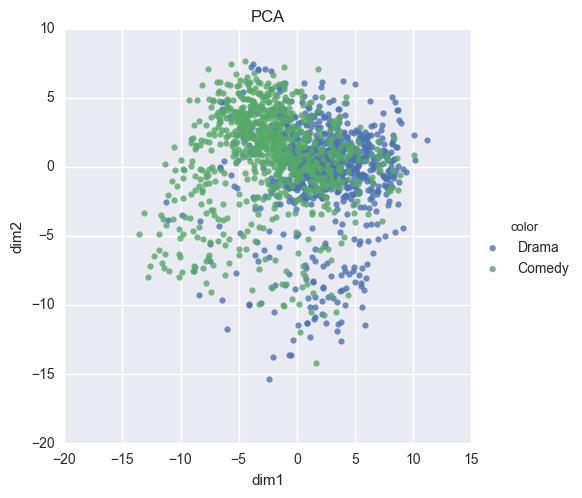

In [534]:
# Using the pca with all the data
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(1600, 64)


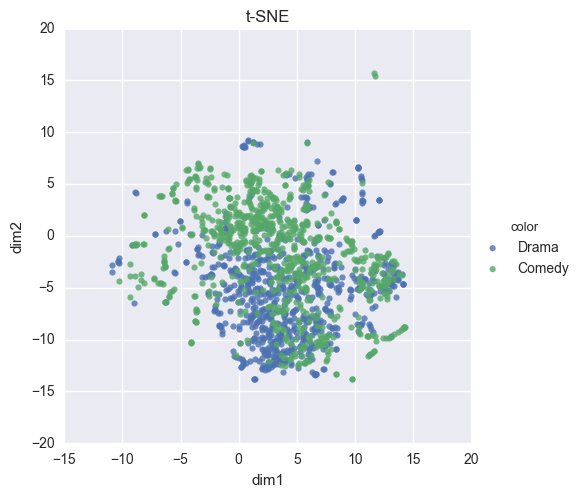

In [535]:
# Recomputing tsne for the selected samples
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(1600, 64)


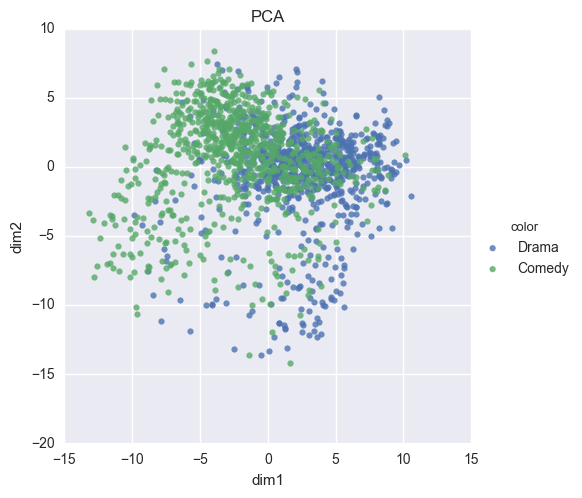

In [536]:
# Recomputing pca for the selected samples
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plots more concrete genres

In [537]:
# War vs Musical 

drama_war_action_genres = ['Drama|War', 'Action|Drama|War']
comedy_romance_genres = ['Comedy|Drama|Romance']
children_comedy = ['Children|Comedy', 'Children|Comedy|Fantasy']
western_genres = ['Western']


df_tsne['genre_3'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_tsne.loc[df_tsne.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_tsne.loc[df_tsne.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_tsne.loc[df_tsne.genres.isin(western_genres), 'genre_3'] = 'Western'



df_pca['genre_3'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_pca.loc[df_pca.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_pca.loc[df_pca.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_pca.loc[df_pca.genres.isin(western_genres), 'genre_3'] = 'Western'



In [257]:
for genre in df_pca.genres.unique():
    #if 'Musical' in genre:
    print(genre)
    print(len(df_pca[df_pca.genres == genre]))
    


Adventure|Drama|Fantasy|Romance
2
Action|Crime
28
Drama|Western
19
Drama
1207
Horror|Mystery|Thriller
54
Action|Crime|Drama
49
Drama|Romance
412
Adventure|Comedy
35
Action|Drama
66
Comedy|Romance
349
Drama|Romance|Thriller
15
Documentary
385
Drama|Sci-Fi
34
Action|Adventure|Animation|Fantasy|Sci-Fi
8
Action|Drama|Thriller
43
Horror
168
Animation|Children|Fantasy
6
Drama|War
139
Drama|Romance|War
34
Comedy|Drama
453
Action|Comedy|Crime
36
Adventure|Children|Sci-Fi
6
Comedy|Crime|Drama
37
Comedy
772
Adventure|Drama|Thriller
7
Action|Adventure|Drama|War
23
Comedy|Drama|Fantasy|Romance
16
Action|Comedy|Crime|Thriller
24
Action|Adventure|Comedy|Fantasy
7
Comedy|Drama|Romance
292
Crime|Drama
154
Drama|Thriller
181
Animation|Comedy|Thriller
1
Action|Adventure|Animation|Children|Sci-Fi
2
Adventure|Drama|Western
7
Action|Animation|Children|Crime
2
Thriller
80
Action|Crime|Thriller
70
Comedy|Drama|Musical|Romance
11
Adventure|Animation|Comedy
11
Comedy|Crime|Drama|Mystery|Romance
3
Action|Fantas

In [437]:

print(len(df_tsne[df_tsne.genre_3 == 'Drama|War|Action']))
print(len(df_tsne[df_tsne.genre_3 == 'Comedy|Romance']))
print(len(df_tsne[df_tsne.genre_3 == 'Children|Comedy']))
print(len(df_tsne[df_tsne.genre_3 == 'Western']))

192
292
94
41


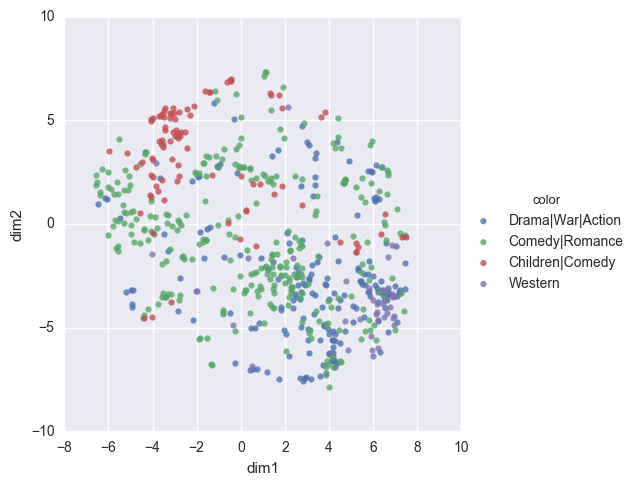

In [538]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

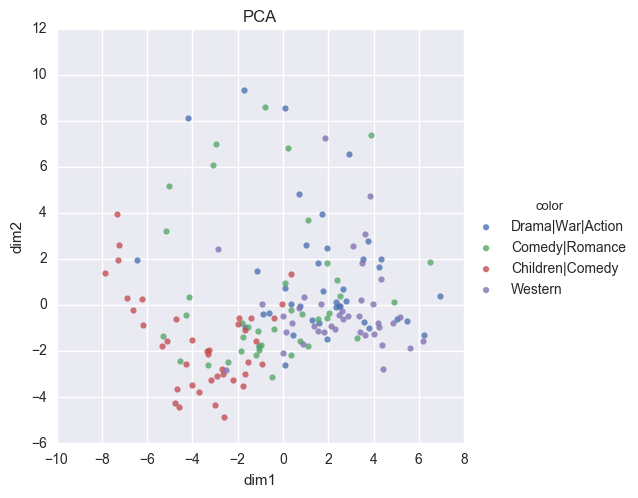

In [506]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()


(619, 64)


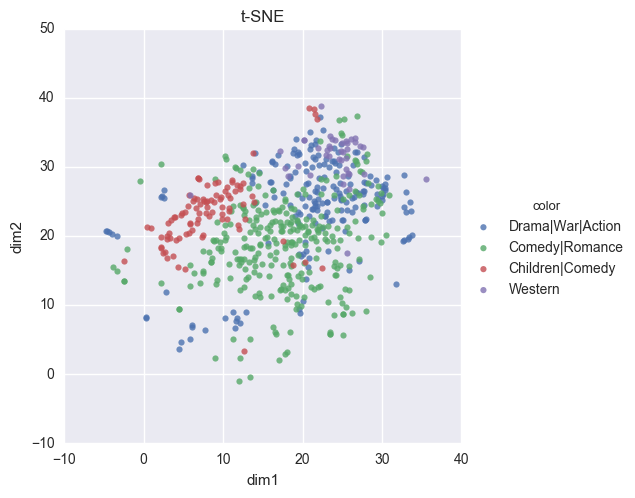

In [539]:
# Recomputing tsne for the selected samples
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(160, 64)


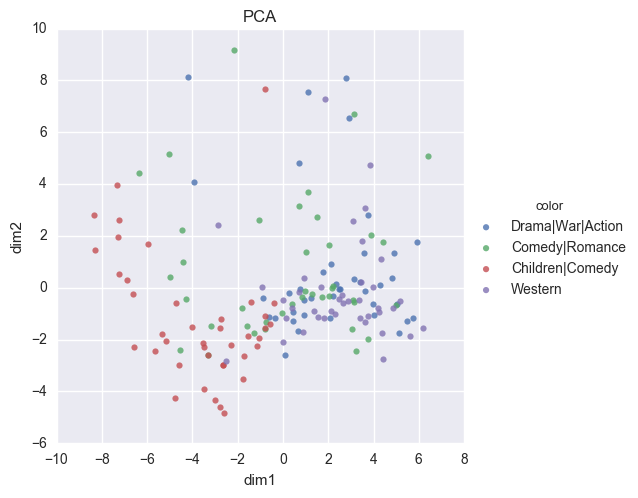

In [508]:
# Recomputing pca for the selected samples
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()



# Plots for specific Movies

In [509]:
df_tsne['movie_id'] = df_tsne['movie_id'].astype(str) 
df_pca['movie_id'] = df_pca['movie_id'].astype(str) 

In [360]:
# Find movie
df_tsne[df_tsne.title.str.contains('Scream')]

,x,y,movie_id,title,genres,years,year_category,horror_genre,genre_1,genre_2,genre_3,saga
154,3.623097,4.776784,86295,Scream 4 (2011),Comedy|Horror|Mystery|Thriller,2011,New (2000 or newer),Null,Null,Null,Null,Null
2485,-3.265696,2.474834,66789,Screamers: The Hunting (2009),Sci-Fi|Thriller,2009,New (2000 or newer),Null,Null,Null,Null,Null
2689,-5.696318,2.287856,76,Screamers (1995),Action|Sci-Fi|Thriller,1995,Null,Null,Null,Null,Null,Null
2869,2.537618,-2.904869,72,Kicking and Screaming (1995),Comedy|Drama,1995,Null,Null,Null,Null,Null,Null
4138,-2.650745,-6.298126,1407,Scream (1996),Comedy|Horror|Mystery|Thriller,1996,Null,Null,Null,Null,Null,Null
4948,2.329708,0.285916,33930,Man with the Screaming Brain (2005),Adventure|Comedy|Sci-Fi,2005,New (2000 or newer),Null,Null,Null,Null,Null
8024,4.006039,2.878306,1717,Scream 2 (1997),Comedy|Horror|Mystery|Thriller,1997,Null,Null,Null,Null,Null,Null
8801,3.961000,2.871820,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000,Null,Null,Null,Null,Null,Null
8971,-6.863285,3.605342,33495,Kicking & Screaming (2005),Comedy,2005,New (2000 or newer),Null,Comedy,Comedy,Null,Null


In [510]:
# Some sagas

star_wars_movies = [260, 1196, 1210, 2628, 5378, 33493]
lord_of_the_rings_movies = [4993, 5952, 7153, 106489, 98809, 118696]
saw_movies = [8957, 39446, 48877, 55577, 63436, 72129, 81535]
#toy_story_movies = [78499, 3114, 1]
rocky_movies = [1954, 2409, 2410, 2411, 2412, 89045]
harry_potter_movies = [81834, 88125, 8368, 4896, 54001, 69844, 40815, 5816]
scream_movies = [86295, 1407, 1717, 3273]
star_wars_movies = [str(i) for i in star_wars_movies]
lord_of_the_rings_movies = [str(i) for i in lord_of_the_rings_movies]
saw_movies = [str(i) for i in saw_movies]
#toy_story_movies = [str(i) for i in toy_story_movies]
rocky_movies = [str(i) for i in rocky_movies]
harry_potter_movies = [str(i) for i in harry_potter_movies]
scream_movies = [str(i) for i in scream_movies]



df_tsne['saga'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_tsne.loc[df_tsne.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_tsne.loc[df_tsne.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_tsne.loc[df_tsne.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_tsne.loc[df_tsne.movie_id.isin(scream_movies), 'saga'] = 'Scream'



df_pca['saga'] = 'Null'
df_pca.loc[df_pca.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_pca.loc[df_pca.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_pca.loc[df_pca.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_pca.loc[df_pca.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_pca.loc[df_pca.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_pca.loc[df_pca.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_pca.loc[df_pca.movie_id.isin(scream_movies), 'saga'] = 'Scream'


len_star_wars = len(df_tsne[df_tsne.saga == 'Star Wars'])
len_lord_of_the_rings = len(df_tsne[df_tsne.saga == 'Lord of the Rings'])
len_saw = len(df_tsne[df_tsne.saga == 'Saw'])
#len_toy_story = len(df_tsne[df_tsne.saga == 'Toy Story'])
len_rocky = len(df_tsne[df_tsne.saga == 'Rocky'])
len_harrypotter = len(df_tsne[df_tsne.saga == 'Harry Potter'])
len_scream = len(df_tsne[df_tsne.saga == 'Scream'])
print(len_star_wars)
print(len_lord_of_the_rings)
print(len_saw)
#print(len_toy_story)
print(len_rocky)
print(len_harrypotter)
print(len_scream)

6
6
7
6
8
4


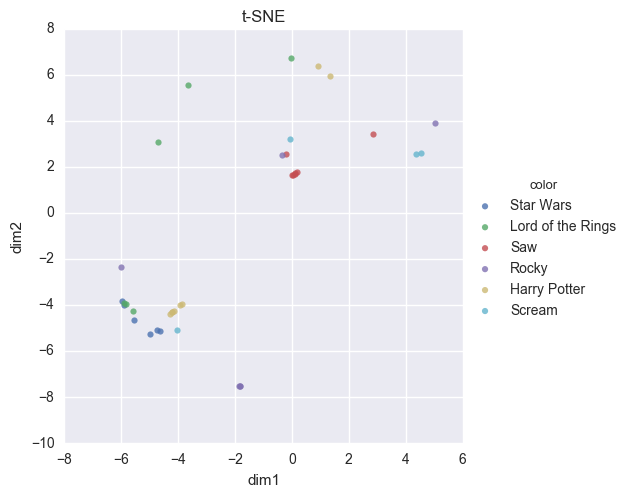

In [511]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()



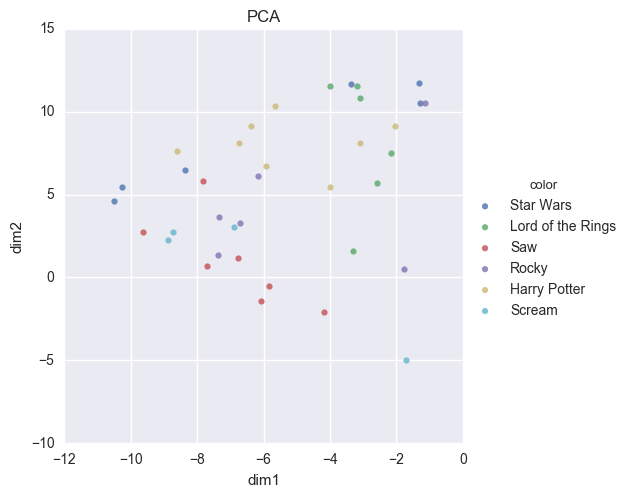

In [445]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_pca[df_pca.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_pca[df_pca.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_pca[df_pca.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_pca[df_pca.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_pca[df_pca.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_pca[df_pca.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(37, 64)


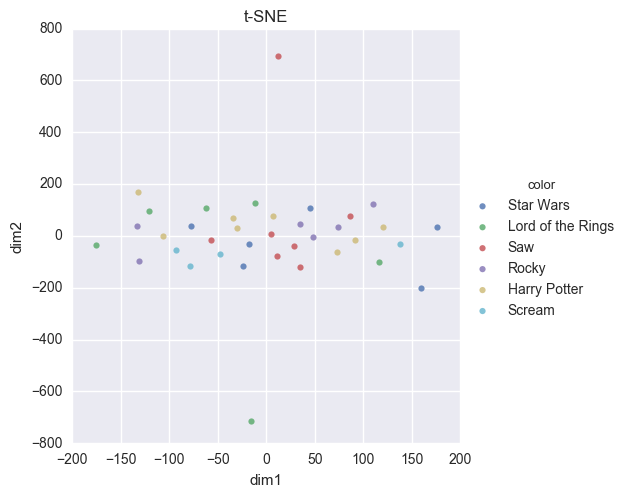

In [446]:
# Recomputing tsne for the selected samples
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['saga']))
g = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
#g.set(ylim=(-0.0005, 0.0005))
#g.set(xlim=(-0.0005, 0.0005))
plt.title('t-SNE')
plt.show()


(37, 64)


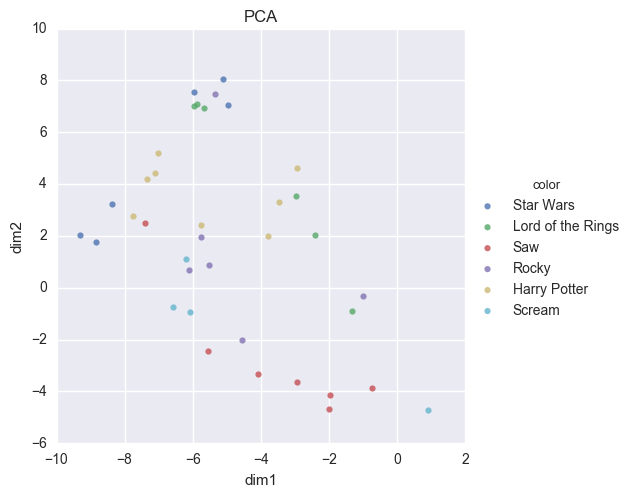

In [373]:
# Recomputing pca for the selected samples
n_samples = 40
df_show1 = df_pca[df_pca.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_pca[df_pca.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_pca[df_pca.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_pca[df_pca.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_pca[df_pca.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_pca[df_pca.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_pca[df_pca.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])

item_vectors = []
for movie_id in df_show.movie_id:
    vector = model[movie_id]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['saga']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()